/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


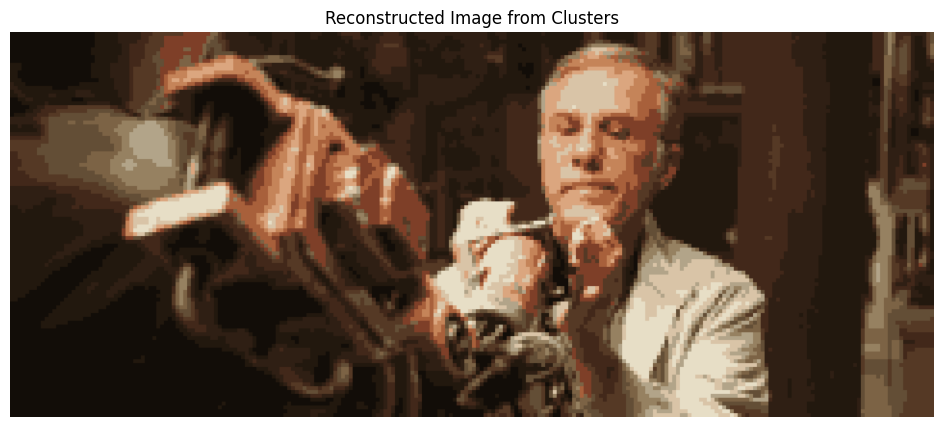

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

def image_to_blocks(img, block_size=(8, 8)):
    img_height, img_width, _ = img.shape
    blocks = []

    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            block = img[y:y+block_size[1], x:x+block_size[0]]
            blocks.append(block)

    return blocks

def calculate_average_color(blocks):
    average_colors = []
    for block in blocks:
        average_color = np.mean(block, axis=(0, 1))
        average_colors.append(average_color)
    return np.array(average_colors)

image_path = '/content/frame1.png'
img = Image.open(image_path)
img = np.array(img)

blocks = image_to_blocks(img)

average_colors = calculate_average_color(blocks)

k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(average_colors)
cluster_assignments = kmeans.labels_
cluster_assignments.shape, cluster_assignments[:10]
cluster_centers = kmeans.cluster_centers_

def reconstruct_image_from_clusters(img, cluster_assignments, cluster_centers, block_size):
    img_height, img_width, _ = img.shape
    reconstructed_img = np.zeros_like(img)
    block_index = 0
    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            if y + block_size[1] <= img_height and x + block_size[0] <= img_width:
                reconstructed_img[y:y + block_size[1], x:x + block_size[0]] = cluster_centers[cluster_assignments[block_index]]
            block_index += 1
    return reconstructed_img

reconstructed_img = reconstruct_image_from_clusters(img, cluster_assignments, cluster_centers, block_size)

fig, axes = plt.subplots(1, figsize=(12, 5))
# axes.imshow(img)
# axes.set_title('Original Image')
# axes.axis('off')

axes.imshow(reconstructed_img.astype(np.uint8))
axes.set_title('Reconstructed Image from Clusters')
axes.axis('off')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


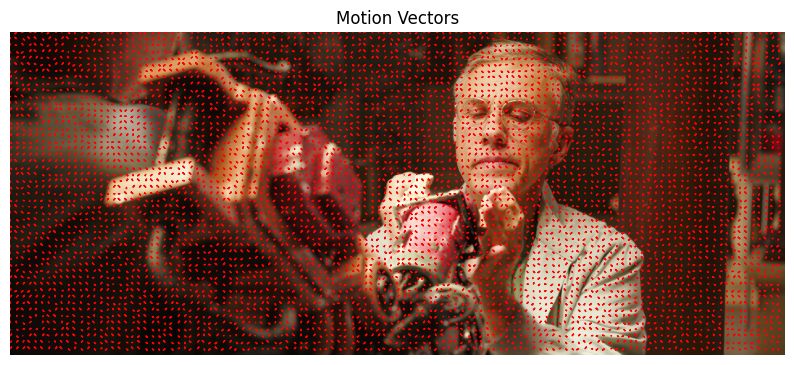

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow

def image_to_blocks(img, block_size=(8, 8)):
    img_height, img_width, _ = img.shape
    blocks = []

    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            block = img[y:y+block_size[1], x:x+block_size[0]]
            blocks.append(block)

    return blocks

def calculate_average_color(blocks):
    average_colors = []
    for block in blocks:
        average_color = np.mean(block, axis=(0, 1))
        average_colors.append(average_color)
    return np.array(average_colors)

def reconstruct_image_from_clusters(img, cluster_assignments, cluster_centers, block_size):
    img_height, img_width, _ = img.shape
    reconstructed_img = np.zeros_like(img)
    block_index = 0
    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            if y + block_size[1] <= img_height and x + block_size[0] <= img_width:
                reconstructed_img[y:y + block_size[1], x:x + block_size[0]] = cluster_centers[cluster_assignments[block_index]]
            block_index += 1
    return reconstructed_img

def get_motion_vector(block, ref_frame, block_pos_x, block_pos_y, search_window):
    block_height, block_width, _ = block.shape
    ref_height, ref_width, _ = ref_frame.shape
    min_sad = float('inf')
    motion_vector = (0, 0)
    search_range_y = [max(0, block_pos_y - search_window),
                      min(ref_height - block_height, block_pos_y + search_window)]
    search_range_x = [max(0, block_pos_x - search_window),
                      min(ref_width - block_width, block_pos_x + search_window)]

    for y in range(search_range_y[0], search_range_y[1]):
        for x in range(search_range_x[0], search_range_x[1]):
            candidate_block = ref_frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block - candidate_block))
            if sad < min_sad:
                min_sad = sad
                motion_vector = (x - block_pos_x, y - block_pos_y)

    return motion_vector

image_path1 = '/content/frame1.png'
image_path2 = '/content/frame2.png'

current_frame = io.imread(image_path1)
next_frame = io.imread(image_path2)

blocks_current = image_to_blocks(current_frame)
average_colors_current = calculate_average_color(blocks_current)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(average_colors_current)
cluster_assignments = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

block_size = (16, 16)
search_window = 5
motion_vectors = []
num_blocks_x = current_frame.shape[1] // block_size[0]

for index, block in enumerate(blocks_current):
    block_pos_y = (index // num_blocks_x) * block_size[1]
    block_pos_x = (index % num_blocks_x) * block_size[0]
    motion_vector = get_motion_vector(block, next_frame, block_pos_x, block_pos_y, search_window)
    motion_vectors.append(motion_vector)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(current_frame)
ax.set_title('Motion Vectors')
ax.axis('off')
for index, vector in enumerate(motion_vectors):
    block_pos_y = (index // num_blocks_x) * block_size[1]
    block_pos_x = (index % num_blocks_x) * block_size[0]
    ax.add_patch(Arrow(block_pos_x, block_pos_y, vector[0], vector[1], width=1, color='red'))

plt.show()


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.metrics import peak_signal_noise_ratio as compare_psnr


video_path = "/content/drive/MyDrive/video_compression/VideoCompressionDataset/AlitaBattleAngel.mkv"
block_size = (16, 16)
num_clusters = 5
seconds_to_process = 2
frame_rate = 24
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video")


def image_to_blocks(img, block_size):
    img_height, img_width, _ = img.shape
    blocks = []
    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            block = img[y:y+block_size[1], x:x+block_size[0]]
            blocks.append(block)
    return blocks

def calculate_average_color(blocks):
    average_colors = []
    for block in blocks:
        average_color = np.mean(block, axis=(0, 1))
        average_colors.append(average_color)
    return np.array(average_colors)

def reconstruct_image_from_clusters(cluster_assignments, cluster_centers, block_size, frame_shape):
    reconstructed_img = np.zeros(frame_shape, dtype=np.uint8)
    block_index = 0
    for y in range(0, frame_shape[0], block_size[1]):
        for x in range(0, frame_shape[1], block_size[0]):
            if y + block_size[1] <= frame_shape[0] and x + block_size[0] <= frame_shape[1]:
                reconstructed_img[y:y + block_size[1], x:x + block_size[0]] = cluster_centers[cluster_assignments[block_index]]
            block_index += 1
    return reconstructed_img

def get_motion_vector(block, ref_frame, block_pos_x, block_pos_y, search_window):
    block_height, block_width, _ = block.shape
    ref_height, ref_width, _ = ref_frame.shape
    min_sad = float('inf')
    motion_vector = (0, 0)
    for y in range(max(0, block_pos_y - search_window), min(block_pos_y + search_window, ref_height - block_height)):
        for x in range(max(0, block_pos_x - search_window), min(block_pos_x + search_window, ref_width - block_width)):
            candidate_block = ref_frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block.astype(int) - candidate_block.astype(int)))
            if sad < min_sad:
                min_sad = sad
                motion_vector = (x - block_pos_x, y - block_pos_y)
    return motion_vector

def encode_video_data(cluster_assignments, motion_vectors, block_size, frame_shape):
    motion_model = np.array(motion_vectors).flatten().tolist()
    return {
        'clusters': cluster_assignments.tolist(),
        'motion_model': motion_model,
        'block_size': block_size,
        'frame_shape': frame_shape
    }

def calculate_motion_vectors(first_frame, next_frame, block_size):
    blocks_first = image_to_blocks(first_frame, block_size)
    motion_vectors = []
    for idx, block in enumerate(blocks_first):
        block_y = (idx // (first_frame.shape[1] // block_size[0])) * block_size[1]
        block_x = (idx % (first_frame.shape[1] // block_size[0])) * block_size[0]
        mv = get_motion_vector(block, next_frame, block_x, block_y, 5)
        motion_vectors.append(mv)
    return motion_vectors

ret, first_frame = cap.read()
if not ret:
    raise IOError("Cannot read the first frame")

blocks_first = image_to_blocks(first_frame, block_size)
average_colors_first = calculate_average_color(blocks_first)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(average_colors_first)
cluster_assignments_first = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

original_frames = [first_frame]
decompressed_frames = []
count = 0

for _ in range(seconds_to_process * frame_rate - 1):
    ret, next_frame = cap.read()
    if not ret:
        break

    count+=1
    print(f"Processing frame {count}")
    original_frames.append(next_frame)
    motion_vectors = calculate_motion_vectors(first_frame, next_frame, block_size)
    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, first_frame.shape)
    decompressed_frame = reconstruct_image_from_clusters(cluster_assignments_first, cluster_centers, block_size, first_frame.shape)
    decompressed_frames.append(decompressed_frame)
    first_frame = next_frame

# Calculate SNR
snr_values = [compare_psnr(orig, decomp) for orig, decomp in zip(original_frames, decompressed_frames)]
average_snr = sum(snr_values) / len(snr_values)

cap.release()

print(f"Average SNR: {average_snr} dB")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Average SNR: 16.057090687040336 dB


In [ ]:
import cv2

output_video_path = 'reconstructed_video.avi'
codec = cv2.VideoWriter_fourcc(*'XVID')
output_frame_rate = frame_rate
print(f"Total frames to write: {len(decompressed_frames)}")
if decompressed_frames:
    print(f"Frame size: {decompressed_frames[0].shape}")
output_size = (decompressed_frames[0].shape[1], decompressed_frames[0].shape[0])
out = cv2.VideoWriter(output_video_path, codec, output_frame_rate, output_size)
for idx, frame in enumerate(decompressed_frames):
    print(f"Writing frame {idx + 1}/{len(decompressed_frames)}")
    out.write(frame)

out.release()
print(f"Video reconstructed and saved to {output_video_path}")


Total frames to write: 23
Frame size: (800, 1920, 3)
Writing frame 1/23
Writing frame 2/23
Writing frame 3/23
Writing frame 4/23
Writing frame 5/23
Writing frame 6/23
Writing frame 7/23
Writing frame 8/23
Writing frame 9/23
Writing frame 10/23
Writing frame 11/23
Writing frame 12/23
Writing frame 13/23
Writing frame 14/23
Writing frame 15/23
Writing frame 16/23
Writing frame 17/23
Writing frame 18/23
Writing frame 19/23
Writing frame 20/23
Writing frame 21/23
Writing frame 22/23
Writing frame 23/23
Video reconstructed and saved to reconstructed_video.avi


In [ ]:
from skimage.metrics import mean_squared_error

def calculate_mse(imageA, imageB):
    """Calculate the Mean Squared Error between two images."""
    err = mean_squared_error(imageA, imageB)
    return err

for i in range(len(decompressed_frames) - 1):
    mse = calculate_mse(decompressed_frames[i], decompressed_frames[i + 1])
    print(f"MSE between frame {i} and frame {i+1}: {mse}")

    if mse > 0.01:
        print(f"Frames {i} and {i+1} are different.")
    else:
        print(f"Frames {i} and {i+1} are similar.")


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

video_path = "/content/drive/MyDrive/video_compression/VideoCompressionDataset/AlitaBattleAngel.mkv"
block_size = (16, 16)
num_clusters = 15
seconds_to_process = 1
frame_rate = 24

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video")

def image_to_blocks(img, block_size):
    img_height, img_width, _ = img.shape
    blocks = []
    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            block = img[y:y+block_size[1], x:x+block_size[0]]
            blocks.append(block)
    return blocks

def calculate_average_color(blocks):
    average_colors = []
    for block in blocks:
        average_color = np.mean(block, axis=(0, 1))
        average_colors.append(average_color)
    return np.array(average_colors)

def reconstruct_image_from_clusters(cluster_assignments, cluster_centers, block_size, frame_shape):
    reconstructed_img = np.zeros(frame_shape, dtype=np.uint8)
    block_index = 0
    for y in range(0, frame_shape[0], block_size[1]):
        for x in range(0, frame_shape[1], block_size[0]):
            if y + block_size[1] <= frame_shape[0] and x + block_size[0] <= frame_shape[1]:
                reconstructed_img[y:y + block_size[1], x:x + block_size[0]] = cluster_centers[cluster_assignments[block_index]]
            block_index += 1
    return reconstructed_img

def get_motion_vector(block, ref_frame, block_pos_x, block_pos_y, search_window):
    block_height, block_width, _ = block.shape
    ref_height, ref_width, _ = ref_frame.shape
    min_sad = float('inf')
    motion_vector = (0, 0)
    for y in range(max(0, block_pos_y - search_window), min(block_pos_y + search_window, ref_height - block_height)):
        for x in range(max(0, block_pos_x - search_window), min(block_pos_x + search_window, ref_width - block_width)):
            candidate_block = ref_frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block.astype(int) - candidate_block.astype(int)))
            if sad < min_sad:
                min_sad = sad
                motion_vector = (x - block_pos_x, y - block_pos_y)
    return motion_vector

def encode_video_data(cluster_assignments, motion_vectors, block_size, frame_shape):
    motion_model = np.array(motion_vectors).flatten().tolist()
    return {
        'clusters': cluster_assignments.tolist(),
        'motion_model': motion_model,
        'block_size': block_size,
        'frame_shape': frame_shape
    }

def calculate_motion_vectors(first_frame, next_frame, block_size):
    blocks_first = image_to_blocks(first_frame, block_size)
    motion_vectors = []
    for idx, block in enumerate(blocks_first):
        block_y = (idx // (first_frame.shape[1] // block_size[0])) * block_size[1]
        block_x = (idx % (first_frame.shape[1] // block_size[0])) * block_size[0]
        mv = get_motion_vector(block, next_frame, block_x, block_y, 5)
        motion_vectors.append(mv)
    return motion_vectors
def apply_motion_vectors_to_frame(frame, motion_vectors, block_size):
    new_frame = np.zeros_like(frame)
    num_blocks_y, num_blocks_x = frame.shape[0] // block_size[1], frame.shape[1] // block_size[0]

    for idx, motion_vector in enumerate(motion_vectors):
        block_y = (idx // num_blocks_x) * block_size[1]
        block_x = (idx % num_blocks_x) * block_size[0]
        new_block_y, new_block_x = block_y + motion_vector[1], block_x + motion_vector[0]

        if 0 <= new_block_x < frame.shape[1] - block_size[0] and 0 <= new_block_y < frame.shape[0] - block_size[1]:
            new_frame[new_block_y:new_block_y + block_size[1], new_block_x:new_block_x + block_size[0]] = frame[block_y:block_y + block_size[1], block_x:block_x + block_size[0]]

    return new_frame

def calculate_residual_frame(actual_frame, predicted_frame):
    """Calculate the residual (difference) frame."""
    residual = cv2.subtract(actual_frame, predicted_frame)
    return residual

def apply_residual_frame(predicted_frame, residual):
    """Apply the residual frame to the predicted frame."""
    reconstructed_frame = cv2.add(predicted_frame, residual)
    return reconstructed_frame

ret, first_frame = cap.read()
if not ret:
    raise IOError("Cannot read the first frame")

blocks_first = image_to_blocks(first_frame, block_size)
average_colors_first = calculate_average_color(blocks_first)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(average_colors_first)
cluster_assignments_first = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

original_frames = [first_frame]
compressed_data = []
count = 0

for _ in range(seconds_to_process * frame_rate - 1):
    ret, next_frame = cap.read()
    if not ret:
        break

    count+=1
    print(f"Processing frame {count}")
    original_frames.append(next_frame)
    motion_vectors = calculate_motion_vectors(first_frame, next_frame, block_size)
    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, first_frame.shape)
    compressed_data.append(encoded_data)

    first_frame = next_frame




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23


In [ ]:
for i in range(1, len(original_frames)):
    current_frame = original_frames[i - 1]
    next_frame = original_frames[i]

    motion_vectors = calculate_motion_vectors(current_frame, next_frame, block_size)
    predicted_next_frame = apply_motion_vectors_to_frame(current_frame, motion_vectors, block_size)
    residual_frame = calculate_residual_frame(next_frame, predicted_next_frame)

    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, current_frame.shape)
    encoded_data['residual'] = residual_frame.tolist()
    compressed_data.append(encoded_data)


In [ ]:
def refresh_needed(reference_frame, new_frame, threshold=0.01):
    """Check if the frame should be refreshed based on a simple threshold."""
    mse = np.mean((reference_frame - new_frame) ** 2)
    return mse > threshold

refresh_rate = 40

decompressed_frames = []
reference_frame = original_frames[0]
frame_count = 0

for encoded_data in compressed_data:
    motion_vectors = np.array(encoded_data['motion_model']).reshape(-1, 2)
    new_frame = apply_motion_vectors_to_frame(reference_frame, motion_vectors, block_size)
    decompressed_frames.append(new_frame)

    frame_count += 1
    if frame_count % refresh_rate == 0 or refresh_needed(reference_frame, new_frame):
        reference_frame = original_frames[frame_count]
    else:
        reference_frame = new_frame


snr_values = [compare_psnr(orig, decomp) for orig, decomp in zip(original_frames, decompressed_frames)]
average_snr = sum(snr_values) / len(snr_values)

cap.release()
print(f"Average SNR: {average_snr} dB")


Average SNR: 22.70128816693809 dB


In [ ]:
def refresh_needed(reference_frame, new_frame, threshold=0.01):
    """Check if the frame should be refreshed based on a simple threshold."""
    mse = np.mean((reference_frame - new_frame) ** 2)
    return mse > threshold

refresh_rate = 5

decompressed_frames = []
reference_frame = original_frames[0]
frame_count = 0

for encoded_data in compressed_data:
    motion_vectors = np.array(encoded_data['motion_model']).reshape(-1, 2)
    residual_frame = np.array(encoded_data['residual'], dtype=np.uint8)

    predicted_frame = apply_motion_vectors_to_frame(reference_frame, motion_vectors, block_size)
    reconstructed_frame = apply_residual_frame(predicted_frame, residual_frame)

    decompressed_frames.append(reconstructed_frame)

    frame_count += 1
    if frame_count % refresh_rate == 0 or refresh_needed(reference_frame, reconstructed_frame):
        reference_frame = original_frames[frame_count]
    else:
        reference_frame = reconstructed_frame

snr_values = [compare_psnr(orig, decomp) for orig, decomp in zip(original_frames, decompressed_frames)]
average_snr = sum(snr_values) / len(snr_values)

cap.release()
print(f"Average SNR: {average_snr} dB")


KeyError: ignored

In [ ]:
total_frames = len(original_frames) - 1
compressed_data = []

for i in range(1, len(original_frames)):
    current_frame = original_frames[i - 1]
    next_frame = original_frames[i]

    motion_vectors = calculate_motion_vectors(current_frame, next_frame, block_size)
    predicted_frame = apply_motion_vectors_to_frame(current_frame, motion_vectors, block_size)
    residual_frame = calculate_residual_frame(next_frame, predicted_frame)

    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, current_frame.shape)
    encoded_data['residual'] = residual_frame.tolist()
    compressed_data.append(encoded_data)
    progress_percentage = (i / total_frames) * 100
    print(f"Compressing frame {i}/{total_frames} ({progress_percentage:.2f}%)")


Compressing frame 1/23 (4.35%)
Compressing frame 2/23 (8.70%)
Compressing frame 3/23 (13.04%)
Compressing frame 4/23 (17.39%)
Compressing frame 5/23 (21.74%)
Compressing frame 6/23 (26.09%)
Compressing frame 7/23 (30.43%)
Compressing frame 8/23 (34.78%)
Compressing frame 9/23 (39.13%)
Compressing frame 10/23 (43.48%)
Compressing frame 11/23 (47.83%)
Compressing frame 12/23 (52.17%)
Compressing frame 13/23 (56.52%)
Compressing frame 14/23 (60.87%)
Compressing frame 15/23 (65.22%)
Compressing frame 16/23 (69.57%)
Compressing frame 17/23 (73.91%)
Compressing frame 18/23 (78.26%)
Compressing frame 19/23 (82.61%)
Compressing frame 20/23 (86.96%)
Compressing frame 21/23 (91.30%)
Compressing frame 22/23 (95.65%)
Compressing frame 23/23 (100.00%)


In [ ]:
decompressed_frames = []
reference_frame = original_frames[0]

for encoded_data in compressed_data:
    motion_vectors = np.array(encoded_data['motion_model']).reshape(-1, 2)

    residual_frame = np.array(encoded_data['residual'], dtype=np.uint8)
    predicted_frame = apply_motion_vectors_to_frame(reference_frame, motion_vectors, block_size)
    reconstructed_frame = apply_residual_frame(predicted_frame, residual_frame)

    decompressed_frames.append(reconstructed_frame)
    reference_frame = reconstructed_frame


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

video_path = "/content/drive/MyDrive/video_compression/VideoCompressionDataset/AlitaBattleAngel.mkv"
block_size = (24, 24)
num_clusters = 5
seconds_to_process = 2
frame_rate = 24
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video")

def image_to_blocks(img, block_size):
    img_height, img_width, _ = img.shape
    blocks = []
    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            block = img[y:y+block_size[1], x:x+block_size[0]]
            blocks.append(block)
    return blocks

def calculate_average_color(blocks):
    average_colors = []
    for block in blocks:
        average_color = np.mean(block, axis=(0, 1))
        average_colors.append(average_color)
    return np.array(average_colors)

def reconstruct_image_from_clusters(cluster_assignments, cluster_centers, block_size, frame_shape):
    reconstructed_img = np.zeros(frame_shape, dtype=np.uint8)
    block_index = 0
    for y in range(0, frame_shape[0], block_size[1]):
        for x in range(0, frame_shape[1], block_size[0]):
            if y + block_size[1] <= frame_shape[0] and x + block_size[0] <= frame_shape[1]:
                reconstructed_img[y:y + block_size[1], x:x + block_size[0]] = cluster_centers[cluster_assignments[block_index]]
            block_index += 1
    return reconstructed_img

def get_motion_vector(block, ref_frame, block_pos_x, block_pos_y, search_window):
    block_height, block_width, _ = block.shape
    ref_height, ref_width, _ = ref_frame.shape
    min_sad = float('inf')
    motion_vector = (0, 0)
    for y in range(max(0, block_pos_y - search_window), min(block_pos_y + search_window, ref_height - block_height)):
        for x in range(max(0, block_pos_x - search_window), min(block_pos_x + search_window, ref_width - block_width)):
            candidate_block = ref_frame[y:y + block_height, x:x + block_width]
            sad = np.sum(np.abs(block.astype(int) - candidate_block.astype(int)))
            if sad < min_sad:
                min_sad = sad
                motion_vector = (x - block_pos_x, y - block_pos_y)
    return motion_vector

def encode_video_data(cluster_assignments, motion_vectors, block_size, frame_shape):
    motion_model = np.array(motion_vectors).flatten().tolist()
    return {
        'clusters': cluster_assignments.tolist(),
        'motion_model': motion_model,
        'block_size': block_size,
        'frame_shape': frame_shape
    }

def calculate_motion_vectors(first_frame, next_frame, block_size):
    blocks_first = image_to_blocks(first_frame, block_size)
    motion_vectors = []
    for idx, block in enumerate(blocks_first):
        block_y = (idx // (first_frame.shape[1] // block_size[0])) * block_size[1]
        block_x = (idx % (first_frame.shape[1] // block_size[0])) * block_size[0]
        mv = get_motion_vector(block, next_frame, block_x, block_y, 5)
        motion_vectors.append(mv)
    return motion_vectors
def apply_motion_vectors_to_frame(frame, motion_vectors, block_size):
    new_frame = np.zeros_like(frame)
    num_blocks_y, num_blocks_x = frame.shape[0] // block_size[1], frame.shape[1] // block_size[0]

    for idx, motion_vector in enumerate(motion_vectors):
        block_y = (idx // num_blocks_x) * block_size[1]
        block_x = (idx % num_blocks_x) * block_size[0]
        new_block_y, new_block_x = block_y + motion_vector[1], block_x + motion_vector[0]

        if 0 <= new_block_x < frame.shape[1] - block_size[0] and 0 <= new_block_y < frame.shape[0] - block_size[1]:
            new_frame[new_block_y:new_block_y + block_size[1], new_block_x:new_block_x + block_size[0]] = frame[block_y:block_y + block_size[1], block_x:block_x + block_size[0]]

    return new_frame

def calculate_residual_frame(actual_frame, predicted_frame):
    """Calculate the residual (difference) frame."""
    residual = cv2.subtract(actual_frame, predicted_frame)
    return residual

def apply_residual_frame(predicted_frame, residual):
    """Apply the residual frame to the predicted frame."""
    reconstructed_frame = cv2.add(predicted_frame, residual)
    return reconstructed_frame

ret, first_frame = cap.read()
if not ret:
    raise IOError("Cannot read the first frame")

blocks_first = image_to_blocks(first_frame, block_size)
average_colors_first = calculate_average_color(blocks_first)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(average_colors_first)
cluster_assignments_first = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

original_frames = [first_frame]
compressed_data = []
count = 0

for _ in range(seconds_to_process * frame_rate - 1):
    ret, next_frame = cap.read()
    if not ret:
        break

    count+=1
    print(f"Processing frame {count}")
    original_frames.append(next_frame)
    motion_vectors = calculate_motion_vectors(first_frame, next_frame, block_size)
    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, first_frame.shape)
    compressed_data.append(encoded_data)

    first_frame = next_frame


total_frames = len(original_frames) - 1
compressed_data = []

for i in range(1, len(original_frames)):
    current_frame = original_frames[i - 1]
    next_frame = original_frames[i]
    motion_vectors = calculate_motion_vectors(current_frame, next_frame, block_size)
    predicted_frame = apply_motion_vectors_to_frame(current_frame, motion_vectors, block_size)
    residual_frame = calculate_residual_frame(next_frame, predicted_frame)

    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, current_frame.shape)
    encoded_data['residual'] = residual_frame.tolist()
    compressed_data.append(encoded_data)

    progress_percentage = (i / total_frames) * 100
    print(f"Compressing frame {i}/{total_frames} ({progress_percentage:.2f}%)")
decompressed_frames = []
reference_frame = original_frames[0]

for encoded_data in compressed_data:
    motion_vectors = np.array(encoded_data['motion_model']).reshape(-1, 2)

    residual_frame = np.array(encoded_data['residual'], dtype=np.uint8)

    predicted_frame = apply_motion_vectors_to_frame(reference_frame, motion_vectors, block_size)
    reconstructed_frame = apply_residual_frame(predicted_frame, residual_frame)

    decompressed_frames.append(reconstructed_frame)
    reference_frame = reconstructed_frame
import cv2

output_video_path = 'reconstructed_video.avi'
codec = cv2.VideoWriter_fourcc(*'XVID')
output_frame_rate = frame_rate

print(f"Total frames to write: {len(decompressed_frames)}")
if decompressed_frames:
    print(f"Frame size: {decompressed_frames[0].shape}")

output_size = (decompressed_frames[0].shape[1], decompressed_frames[0].shape[0])

out = cv2.VideoWriter(output_video_path, codec, output_frame_rate, output_size)

for idx, frame in enumerate(decompressed_frames):
    print(f"Writing frame {idx + 1}/{len(decompressed_frames)}")
    out.write(frame)
out.release()

print(f"Video reconstructed and saved to {output_video_path}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Compressing frame 1/47 (2.13%)
Compressing frame 2/47 (4.26%)
Compres

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

video_path = "/content/drive/MyDrive/video_compression/VideoCompressionDataset/AlitaBattleAngel.mkv"
block_size = (16, 16)
num_clusters = 5
seconds_to_process = 2
frame_rate = 24
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("Cannot open video")

def image_to_blocks(img, block_size):
    img_height, img_width, _ = img.shape
    blocks = []
    for y in range(0, img_height, block_size[1]):
        for x in range(0, img_width, block_size[0]):
            block = img[y:y+block_size[1], x:x+block_size[0]]
            blocks.append(block)
    return blocks

def calculate_average_color(blocks):
    average_colors = []
    for block in blocks:
        average_color = np.mean(block, axis=(0, 1))
        average_colors.append(average_color)
    return np.array(average_colors)

def reconstruct_image_from_clusters(cluster_assignments, cluster_centers, block_size, frame_shape):
    reconstructed_img = np.zeros(frame_shape, dtype=np.uint8)
    block_index = 0
    for y in range(0, frame_shape[0], block_size[1]):
        for x in range(0, frame_shape[1], block_size[0]):
            if y + block_size[1] <= frame_shape[0] and x + block_size[0] <= frame_shape[1]:
                reconstructed_img[y:y + block_size[1], x:x + block_size[0]] = cluster_centers[cluster_assignments[block_index]]
            block_index += 1
    return reconstructed_img


def get_motion_vector(block, ref_frame, block_pos_x, block_pos_y, search_window):
    block_height, block_width, _ = block.shape
    ref_height, ref_width, _ = ref_frame.shape
    min_ssd = float('inf')
    motion_vector = (0, 0)

    for y in range(max(0, block_pos_y - search_window), min(block_pos_y + search_window, ref_height - block_height)):
        for x in range(max(0, block_pos_x - search_window), min(block_pos_x + search_window, ref_width - block_width)):
            candidate_block = ref_frame[y:y + block_height, x:x + block_width]
            ssd = np.sum((block.astype(int) - candidate_block.astype(int))**2)
            if ssd < min_ssd:
                min_ssd = ssd
                motion_vector = (x - block_pos_x, y - block_pos_y)

    return motion_vector


def encode_video_data(cluster_assignments, motion_vectors, block_size, frame_shape):
    motion_model = np.array(motion_vectors).flatten().tolist()
    return {
        'clusters': cluster_assignments.tolist(),
        'motion_model': motion_model,
        'block_size': block_size,
        'frame_shape': frame_shape
    }


def diamond_search(block, ref_frame, block_pos_x, block_pos_y, max_search_range):
    block_height, block_width, _ = block.shape
    ref_height, ref_width, _ = ref_frame.shape

    small_diamond = [(0, -1), (-1, 0), (1, 0), (0, 1), (0, 0)]
    large_diamond = [(-2, 0), (0, -2), (2, 0), (0, 2)] + small_diamond

    def get_sad(center_x, center_y, ref_block):
        y1, y2 = max(center_y, 0), min(center_y + block_height, ref_height)
        x1, x2 = max(center_x, 0), min(center_x + block_width, ref_width)
        sad = np.sum(np.abs(block - ref_block[y1:y2, x1:x2]))
        return sad

    min_sad = float('inf')
    motion_vector = (0, 0)
    center_x, center_y = block_pos_x, block_pos_y

    for dx, dy in large_diamond:
        x, y = center_x + dx, center_y + dy
        if 0 <= x < ref_width - block_width and 0 <= y < ref_height - block_height:
            sad = get_sad(x, y, ref_frame)
            if sad < min_sad:
                min_sad = sad
                motion_vector = (x - block_pos_x, y - block_pos_y)

    center_x, center_y = center_x + motion_vector[0], center_y + motion_vector[1]
    for dx, dy in small_diamond:
        x, y = center_x + dx, center_y + dy
        if 0 <= x < ref_width - block_width and 0 <= y < ref_height - block_height:
            sad = get_sad(x, y, ref_frame)
            if sad < min_sad:
                min_sad = sad
                motion_vector = (x - block_pos_x, y - block_pos_y)

    return motion_vector

def calculate_motion_vectors(first_frame, next_frame, block_size):
    blocks_first = image_to_blocks(first_frame, block_size)
    motion_vectors = []
    for idx, block in enumerate(blocks_first):
        block_y = (idx // (first_frame.shape[1] // block_size[0])) * block_size[1]
        block_x = (idx % (first_frame.shape[1] // block_size[0])) * block_size[0]
        mv = diamond_search(block, next_frame, block_x, block_y, 5)
        motion_vectors.append(mv)
    return motion_vectors
import numpy as np

def apply_motion_vectors_to_frame(frame, motion_vectors, block_size):
    new_frame = np.zeros_like(frame)
    num_blocks_y, num_blocks_x = frame.shape[0] // block_size[1], frame.shape[1] // block_size[0]

    for idx, motion_vector in enumerate(motion_vectors):
        block_y = (idx // num_blocks_x) * block_size[1]
        block_x = (idx % num_blocks_x) * block_size[0]
        new_block_y, new_block_x = block_y + motion_vector[1], block_x + motion_vector[0]

        if 0 <= new_block_x < frame.shape[1] - block_size[0] and 0 <= new_block_y < frame.shape[0] - block_size[1]:
            new_frame[new_block_y:new_block_y + block_size[1], new_block_x:new_block_x + block_size[0]] = frame[block_y:block_y + block_size[1], block_x:block_x + block_size[0]]

    return new_frame

def calculate_residual_frame(actual_frame, predicted_frame):
    """Calculate the residual (difference) frame."""
    residual = cv2.subtract(actual_frame, predicted_frame)
    return residual

def apply_residual_frame(predicted_frame, residual):
    """Apply the residual frame to the predicted frame."""
    reconstructed_frame = cv2.add(predicted_frame, residual)
    return reconstructed_frame

ret, first_frame = cap.read()
if not ret:
    raise IOError("Cannot read the first frame")

blocks_first = image_to_blocks(first_frame, block_size)
average_colors_first = calculate_average_color(blocks_first)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(average_colors_first)
cluster_assignments_first = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

original_frames = [first_frame]
compressed_data = []
count = 0

for _ in range(seconds_to_process * frame_rate - 1):
    ret, next_frame = cap.read()
    if not ret:
        break

    count+=1
    print(f"Processing frame {count}")
    original_frames.append(next_frame)
    motion_vectors = calculate_motion_vectors(first_frame, next_frame, block_size)
    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, first_frame.shape)
    compressed_data.append(encoded_data)

    first_frame = next_frame


total_frames = len(original_frames) - 1
compressed_data = []

for i in range(1, len(original_frames)):
    current_frame = original_frames[i - 1]
    next_frame = original_frames[i]
    motion_vectors = calculate_motion_vectors(current_frame, next_frame, block_size)
    predicted_frame = apply_motion_vectors_to_frame(current_frame, motion_vectors, block_size)
    residual_frame = calculate_residual_frame(next_frame, predicted_frame)
    encoded_data = encode_video_data(cluster_assignments_first, motion_vectors, block_size, current_frame.shape)
    encoded_data['residual'] = residual_frame.tolist()
    compressed_data.append(encoded_data)

    progress_percentage = (i / total_frames) * 100
    print(f"Compressing frame {i}/{total_frames} ({progress_percentage:.2f}%)")

refresh_rate = 5
def refresh_needed(frame_count, refresh_rate):
    return frame_count % refresh_rate == 0

decompressed_frames = []
reference_frame = original_frames[0]
frame_count = 0

for encoded_data in compressed_data:
    frame_count += 1
    motion_vectors = np.array(encoded_data['motion_model']).reshape(-1, 2)
    residual_frame = np.array(encoded_data['residual'], dtype=np.uint8)

    predicted_frame = apply_motion_vectors_to_frame(reference_frame, motion_vectors, block_size)
    reconstructed_frame = apply_residual_frame(predicted_frame, residual_frame)

    decompressed_frames.append(reconstructed_frame)

    if refresh_needed(frame_count, refresh_rate):
        reference_frame = original_frames[min(frame_count, len(original_frames) - 1)]
    else:
        reference_frame = reconstructed_frame

import cv2

output_video_path = 'reconstructed_video.avi'
codec = cv2.VideoWriter_fourcc(*'XVID')
output_frame_rate = frame_rate

print(f"Total frames to write: {len(decompressed_frames)}")
if decompressed_frames:
    print(f"Frame size: {decompressed_frames[0].shape}")

output_size = (decompressed_frames[0].shape[1], decompressed_frames[0].shape[0])
out = cv2.VideoWriter(output_video_path, codec, output_frame_rate, output_size)
for idx, frame in enumerate(decompressed_frames):
    print(f"Writing frame {idx + 1}/{len(decompressed_frames)}")
    out.write(frame)

out.release()

print(f"Video reconstructed and saved to {output_video_path}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing frame 1
Processing frame 2
Processing frame 3
Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Compressing frame 1/47 (2.13%)
Compressing frame 2/47 (4.26%)
Compres

In [ ]:
refresh_rate = 4
def refresh_needed(frame_count, refresh_rate):
    return frame_count % refresh_rate == 0
decompressed_frames = []
reference_frame = original_frames[0]
frame_count = 0

for encoded_data in compressed_data:
    frame_count += 1
    motion_vectors = np.array(encoded_data['motion_model']).reshape(-1, 2)
    residual_frame = np.array(encoded_data['residual'], dtype=np.uint8)

    predicted_frame = apply_motion_vectors_to_frame(reference_frame, motion_vectors, block_size)
    reconstructed_frame = apply_residual_frame(predicted_frame, residual_frame)

    decompressed_frames.append(reconstructed_frame)

    if refresh_needed(frame_count, refresh_rate):
        reference_frame = original_frames[min(frame_count, len(original_frames) - 1)]
    else:
        reference_frame = reconstructed_frame

import cv2

output_video_path = 'reconstructed_video.avi'
codec = cv2.VideoWriter_fourcc(*'XVID')
output_frame_rate = frame_rate

print(f"Total frames to write: {len(decompressed_frames)}")
if decompressed_frames:
    print(f"Frame size: {decompressed_frames[0].shape}")

output_size = (decompressed_frames[0].shape[1], decompressed_frames[0].shape[0])
out = cv2.VideoWriter(output_video_path, codec, output_frame_rate, output_size)

for idx, frame in enumerate(decompressed_frames):
    print(f"Writing frame {idx + 1}/{len(decompressed_frames)}")
    out.write(frame)

out.release()

print(f"Video reconstructed and saved to {output_video_path}")

Total frames to write: 47
Frame size: (800, 1920, 3)
Writing frame 1/47
Writing frame 2/47
Writing frame 3/47
Writing frame 4/47
Writing frame 5/47
Writing frame 6/47
Writing frame 7/47
Writing frame 8/47
Writing frame 9/47
Writing frame 10/47
Writing frame 11/47
Writing frame 12/47
Writing frame 13/47
Writing frame 14/47
Writing frame 15/47
Writing frame 16/47
Writing frame 17/47
Writing frame 18/47
Writing frame 19/47
Writing frame 20/47
Writing frame 21/47
Writing frame 22/47
Writing frame 23/47
Writing frame 24/47
Writing frame 25/47
Writing frame 26/47
Writing frame 27/47
Writing frame 28/47
Writing frame 29/47
Writing frame 30/47
Writing frame 31/47
Writing frame 32/47
Writing frame 33/47
Writing frame 34/47
Writing frame 35/47
Writing frame 36/47
Writing frame 37/47
Writing frame 38/47
Writing frame 39/47
Writing frame 40/47
Writing frame 41/47
Writing frame 42/47
Writing frame 43/47
Writing frame 44/47
Writing frame 45/47
Writing frame 46/47
Writing frame 47/47
Video reconstruc

In [ ]:
# Calculate SNR
snr_values = [compare_psnr(orig, decomp) for orig, decomp in zip(original_frames, decompressed_frames)]
average_snr = sum(snr_values) / len(snr_values)
cap.release()

print(f"Average SNR: {average_snr} dB")

Average SNR: 24.12059339585315 dB
